In [1]:
import warnings
# Comment this
warnings.filterwarnings('ignore')  

import pandas as pd
from utils import clean_text
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading Data

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.30,Froud app i recharge 199 but not done also sen...,NaN,1
2,93ff57f7-9e02-4fa9-b779-3db82b8af0a4,52.0,2.12,Waste to write comments also,Waste no use,2
3,df2dcdef-c09a-4f35-afab-e1231d3fec9a,62.0,2.21,Nice apo,NaN,5
4,11f8f968-4cec-4424-8427-9709ab05b5be,69.0,2.28,Good nice app,NaN,5


### Data Insights and Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 6 columns):
id                  5693 non-null object
App Version Code    4554 non-null float64
App Version Name    4554 non-null float64
Review Text         5692 non-null object
Review Title        602 non-null object
Star Rating         5693 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 266.9+ KB


* Only one "Review Text" is NULL
* Many "Review Title" are NULL

In [4]:
# Print the row with "Review Text" to check wether we can use the title.
review_nan_index = df.index[df["Review Text"].isna()][0]
print(df.iloc[review_nan_index])

id                  e5c14e2d-ab19-48c6-a19f-ed19f21c0851
App Version Code                                     NaN
App Version Name                                     NaN
Review Text                                          NaN
Review Title                           Fine but not good
Star Rating                                            3
Name: 1556, dtype: object


- Looks usable

In [5]:
# Replace Nan with empty string
df.fillna("", inplace=True)

# df["sentence"] = df.apply(lambda row: ) 
df['text'] = df['Review Title'] + " " + df['Review Text']
df.drop(["Review Text", "Review Title", "id", "App Version Code", "App Version Name"], 
        inplace=True, axis=1)
df.rename(columns={"Star Rating":"sentiment"}, inplace=True)
df.head()

,sentiment,text
0,1,Very bad wallet balance not use.
1,1,Froud app i recharge 199 but not done also se...
2,2,Waste no use Waste to write comments also
3,5,Nice apo
4,5,Good nice app


Need to take care of wrong spelling, Hindi Words
 - Use char level models: FastTxt
 - SpellCheckers

###  Clean Text

In [6]:
df.text = df.text.apply(clean_text)
df["word_count"] = df.text.apply(lambda para : len(para.split()))

### Visualizing Data

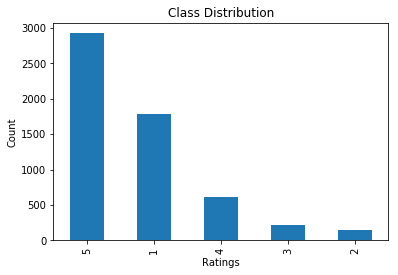

In [7]:
# checking class imbalance
ax = df.sentiment.value_counts().plot(kind='bar',
                                title='Class Distribution')
ax.set_xlabel("Ratings")
ax.set_ylabel("Count")
plt.show()

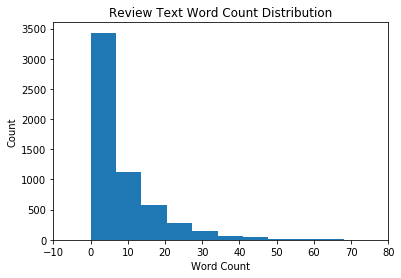

In [8]:
# Review Text Word Count Distribution
# sns.distplot(df.word_count)
ax = df.word_count.plot(kind='hist', 
                        bins = 50,
                        title='Review Text Word Count Distribution')
ax.set_xlabel("Word Count")
ax.set_ylabel("Count")
ax.set_xlim(-10, 80)
plt.show()

In [9]:
# Need to use fasttxt, Checkign if small len are outliers.
# Outliers, but seems like can be used, otherwise less data
# Try keeping and removing both
single_word_table = pd.pivot_table(df[df.word_count == 1], columns=["text"], index=["sentiment"],
                                  aggfunc = 'count')
print(single_word_table[:10])

          word_count                                                         \
text              aa abhishek akakakw amaz aswm averag awasom awesom awosom   
sentiment                                                                     
1                NaN      NaN     NaN  NaN  NaN    NaN    NaN    NaN    NaN   
2                NaN      1.0     NaN  NaN  NaN    NaN    NaN    NaN    NaN   
3                NaN      NaN     NaN  NaN  NaN    1.0    NaN    NaN    NaN   
4                NaN      NaN     NaN  1.0  NaN    NaN    NaN    5.0    NaN   
5                1.0      NaN     1.0  8.0  1.0    NaN    1.0   62.0    1.0   

                ...                                                       \
text      awsm  ... winking_fac wonder worest wors worst  wow wrost   ye   
sentiment       ...                                                        
1          NaN  ...         NaN    NaN    1.0  1.0   7.0  NaN   1.0  NaN   
2          NaN  ...         NaN    NaN    NaN  NaN   NaN  NaN  

In [10]:
# Rechecking df before training
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 3 columns):
sentiment     5693 non-null int64
text          5693 non-null object
word_count    5693 non-null int64
dtypes: int64(2), object(1)
memory usage: 133.5+ KB


### Learning

In [20]:
# Model
# Return Model List, Model Socre, Best Model
# Verbose: True: print cross validation results
def train_model(X, y, verbose = True):
    svm_pgrid = {"C": [1, 3],
                "kernel": ['rbf', 'poly'],
                "class_weight":[None, "balanced"]}

    rf_pgrid = {"n_estimators": [10, 50, 100, 200],
                "max_depth": [2, 5, 10, 15],
                "class_weight":[None, "balanced"]}

    nn_pgrid = {"n_neighbors": [5, 10, 15]}

    cv = 5 # 5-fold
    scoring_metric = 'f1_weighted'

    # Classifiers with GridSearchCv with startifiedKfold and 
    # wieghtedf1 score and balanced
    classifiers = [
        ["SVC", GridSearchCV(estimator=SVC(), 
                             param_grid=svm_pgrid, cv=cv, 
                             scoring=scoring_metric, iid=False)],
        ["Random Forest", GridSearchCV(estimator=RandomForestClassifier(),
                                      param_grid=rf_pgrid, cv=cv,
                                      scoring=scoring_metric, iid=False)],
        ["Nearest Neighbour", GridSearchCV(estimator=KNeighborsClassifier(),
                                          param_grid=nn_pgrid, cv=cv, 
                                        scoring=scoring_metric, iid=False)]
    ]
    
    CV_classifiers = []
    CV_best_scores = []
    
    for name, clf in classifiers:
        clf.fit(X, y)
        CV_classifiers.append(clf.best_estimator_)
        CV_best_scores.append(clf.best_score_)
        if verbose:
            print("--------------------------------------------------------------")
            print("Cross Validation Results for:", name)
            print(clf.cv_results_)
            print("--------------------------------------------------------------\n\n")
        print("Classifier:", name, "=> Wieghted F1:", clf.best_score_)
        
    best_model = CV_classifiers[CV_best_scores.index(max(CV_best_scores))]
    return CV_classifiers, CV_best_scores, best_model, max(CV_best_scores)


In [ ]:
# TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=1.0, min_df=1)
Xnorm = tfidf_vectorizer.fit_transform(df.text)
ynorm = df.sentiment
model, score, best_model, best_score = train_model(Xnorm, ynorm, verbose=False)
print("Best F1 score:", best_score)

In [18]:
# Filter outlier
pass

In [ ]:
word_count_table = pd.pivot_table(df, index=["word_count"], columns=["sentiment"],
                                  aggfunc = 'count')
print(word_count_table[:10])

In [ ]:
gr = df.groupby("sentiment")
print(gr.word_count.sum())

In [ ]:
# NAN Functions
# Sum
print(df["Review Text"].isna().sum())

# Any missing value
print(df["Review Text"].isnull().values.any())

# Print value with NAN rows
print(df.isnull().sum())

In [ ]:

df['text'].loc[21]

In [ ]:
a = df.text.str.replace("(<br/>)", "")

In [ ]:
type(a)

In [ ]:
# Creating the DataFrame 
dummy = pd.DataFrame({'Date':['10/2/2011', '11/2/2011', '12/2/2011', '13/2/2011'], 
                    'Event':['Music', 'Poetry', 'Theatre', 'Comedy'], 
                    'Cost':[10000, 5000, 15000, 2000]}) 

In [ ]:
fn = lambda x: x+"_add"

In [ ]:
fn2 = lambda x: x.str + "_new"

In [ ]:
dummy['as'] = 2*dummy['Cost']


In [ ]:
dummy['Event'] = dummy['Event']+"_sim"

In [ ]:
dummy['Event'] = fn2(dummy['Event'])

In [ ]:
dummy.head()

In [ ]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

In [ ]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv,
                       iid=False)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()